In [873]:
import re

import numpy as np
import pandas as pd
import datetime
import random

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# models
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

import warnings
###font 다운로드 필요: https://hangeul.naver.com/
# font manager을 활용해서 설정
# site-packages/matplotlib/mpl-data/fonts 로 ttf 파일 이동
# from matplotlib import font_manager
# font_manager._rebuild()
warnings.filterwarnings(action='ignore')
plt.rc('font', family='NanumGothic')
matplotlib.rcParams['axes.unicode_minus']=False


In [874]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
age_gender_info = pd.read_csv('../data/age_gender_info.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')
# ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
#        '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
#        '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수']
duplicate_cols = ['임대건물구분', '공급유형', '자격유형', '전용면적', '전용면적별세대수', '임대보증금', '임대료']
unique_cols = ['총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수']
target_col = ['등록차량수']
id_col = ['단지코드']

In [875]:
# fix errors
# number 3 error
train = train[~train['단지코드'].isin(['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'])]
###number 2 error
train = train[~train['단지코드'].isin(['C2085', 'C1397', 'C2431', 'C1649', 'C1036'])]

##drop duplicate false/true
Option = False
if Option:
    train = train.drop_duplicates()
    test = test.drop_duplicates()
if not Option:
    pass


In [876]:
# train, test 합치기
train_ids = np.unique(train['단지코드'])
test_ids = sample_submission['code']
df = pd.concat([train, test])

In [877]:
### 버스 지하철
cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
df[cols] = df[cols].fillna(0)

In [878]:
###자격유형 전처리
### test 데이터 자격유형 null값처리
df.loc[df.단지코드.isin(['C2411']) & df.자격유형.isnull(), '자격유형'] = 'A'
df.loc[df.단지코드.isin(['C2253']) & df.자격유형.isnull(), '자격유형'] = 'C'

df.loc[df.자격유형.isin(['B','F','O']),"자격유형"] = '이외'

###단지 drop 확인
df = df.drop(['자격유형'],axis=1)

In [879]:
### 임대보증금 임대료
df.loc[df.임대보증금 == '-', '임대보증금'] = np.nan
df['임대보증금'] = df['임대보증금'].astype(float)
df.loc[df.임대료 == '-', '임대료'] = np.nan
df['임대료'] = df['임대료'].astype(float)
df[['임대보증금', '임대료']] = df[['임대보증금', '임대료']].fillna(0)

# df_agg 생성, with only unique columns
df_agg = df[id_col + unique_cols + target_col].drop_duplicates().set_index('단지코드')

In [880]:
###reshape_cat_features 함수
def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col,
                                                                           values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:  col + "_existence" for col in res.columns})
    return res


###count_cat_features 함수
def count_cat_features(data, cast_col):
    new_df = data.groupby(['단지코드', cast_col]).agg({"임대료": "count"}).reset_index(cast_col).pivot(columns=[cast_col])
    new_df = new_df.fillna(0)
    new_df.columns = new_df.columns.droplevel(0)
    new_df.columns = [column + "_count" for column in new_df.columns]
    return new_df


## 자격유형,임대건물 구분 존재유무 합쳐주기
df_agg = pd.concat([df_agg,
                    reshape_cat_features(data=df, cast_col='임대건물구분', value_col='counter'),
                    reshape_cat_features(data=df, cast_col='공급유형', value_col='counter'),
                    reshape_cat_features(data=df, cast_col='자격유형', value_col='counter')
                   ], axis=1)

###자격유형,임대건물 구분 개수 합쳐주기
df_agg = pd.concat([df_agg,
                    count_cat_features(data=df, cast_col='임대건물구분'),
                    count_cat_features(data=df, cast_col='공급유형'),
                    count_cat_features(data=df, cast_col='자격유형')
                   ], axis=1)

In [881]:
###총 임대 가구수 변수 생성
total_houses = df.groupby('단지코드').agg({'전용면적별세대수': sum})
total_houses.columns = ['전용면적별세대수_total']

###전용면적별 비율 더해주기
def sum_cat_features(data, cast_col, sum_col):
    new_df = data.groupby(['단지코드', cast_col]).agg({sum_col: sum}).reset_index(cast_col).pivot(columns=[cast_col])
    new_df = new_df.fillna(0)
    new_df.columns = new_df.columns.droplevel(0)
    new_df.columns = [str(column) + "_portion" for column in new_df.columns]
    return new_df

df['전용면적%10']= (df['전용면적']//10)*10
df.loc[df['전용면적%10']>60,'전용면적%10'] = 60
df.loc[df['전용면적%10']<20,'전용면적%10'] = 20
new_df = sum_cat_features(df,'전용면적%10','전용면적별세대수')
columns=new_df.columns
new_df = pd.concat([new_df, total_houses],axis=1)
for column in columns:
    new_df[column]=new_df[column]/new_df['전용면적별세대수_total']
# new_df = new_df.drop(['전용면적별세대수'],axis=1)
df_agg= pd.concat([df_agg, new_df],axis=1)
#drop 전용면적별세대수_total
df_agg = df_agg.drop(['전용면적별세대수_total'], axis=1)


In [882]:
##옆면적 더해주기
df['전용면적*전용면적별 세대수'] = df['전용면적']*df['전용면적별세대수']
df_sum_agg = df.groupby('단지코드').agg({'전용면적*전용면적별 세대수':sum})
df_agg = pd.concat([df_agg, df_sum_agg],axis=1)

###(전용면적)*(전용면적별 세대수)/총세대수
df_agg['전용면적*전용면적별 세대수/총 세대수'] = df_agg['전용면적*전용면적별 세대수']/df_agg['총세대수']

In [883]:
###local parking 추가
local_parking = pd.read_csv('../data/local parking.csv')
local_parking['호수/총대수'] = local_parking['호수']/local_parking['총대수']
df_agg = pd.merge(df_agg.reset_index(),local_parking[{'호수/총대수','지역'}],how='left',on='지역').set_index('단지코드')

In [884]:
###gender_info 성별별 차소유 비율과 합쳐 추가
age_gender_info = age_gender_info.set_index('지역')
age_gender_info['90대(남자)']=age_gender_info['90대(남자)']+age_gender_info['100대(남자)']
age_gender_info['90대(여자)']=age_gender_info['90대(여자)']+age_gender_info['100대(여자)']
age_gender_info['10대(남자)']=age_gender_info['10대미만(남자)']+age_gender_info['10대(남자)']
age_gender_info['10대(여자)']=age_gender_info['10대미만(여자)']+age_gender_info['10대(여자)']
age_gender_info= age_gender_info.drop(columns=['100대(남자)','100대(여자)','10대미만(남자)','10대미만(여자)'])
men_compile = re.compile("남자")
men_columns = []
women_compile = re.compile("여자")
women_columns = []
for column in age_gender_info.columns:
    if men_compile.search(column):
        men_columns.append(column)
    if women_compile.search(column):
        women_columns.append(column)
gender_age_car_data = pd.read_csv("../data/gender_age_car_data.csv")
age_gender_info['men_sum']=age_gender_info[men_columns].values.dot(gender_age_car_data['men'])
age_gender_info['women_sum']=age_gender_info[women_columns].values.dot(gender_age_car_data['women'])
age_gender_info['men_women_sum']=age_gender_info['men_sum']+age_gender_info['women_sum']
age_gender_info=age_gender_info['men_women_sum'].reset_index()
df_agg = pd.merge(df_agg.reset_index(),age_gender_info, how='left', on='지역').set_index('단지코드')

###trainset만 활용한 순위 변수 추가
train = df[~df.등록차량수.isna()]
test=df[df.등록차량수.isna()]

qualification_map=dict()
count=0
for i in train['자격유형'].value_counts().index:
    qualification_map[i]=count
    count+=1

df['자격유형_rank'] = df['자격유형'].map(qualification_map)

supply_map=dict()
count=0
for i in train['공급유형'].value_counts().index:
    supply_map[i]=count
    count+=1

df['공급유형_rank'] = df['공급유형'].map(supply_map)

rank_to_agg = df[['단지코드','자격유형_rank','공급유형_rank']].groupby('단지코드').agg({'자격유형_rank':[sum, "mean", "std","min","max"], '공급유형_rank':[sum, "mean", "std","min","max"]})
rank_to_agg.columns= [ i+"_" +j for i,j in rank_to_agg.columns ]

df_agg = pd.concat([df_agg,
                    rank_to_agg,
                   ], axis=1)

#정규화
train_agg = df_agg[~df_agg.등록차량수.isna()]
numeric_features = train_agg.select_dtypes(exclude="object").columns.drop(['등록차량수']).tolist()
scaler = StandardScaler()
scaler.fit(train_agg[numeric_features])
scaled_features_train = pd.DataFrame(scaler.transform(train_agg[numeric_features])).fillna(0)
scaled_features= pd.DataFrame(scaler.transform(df_agg[numeric_features])).fillna(0)

#pca
pca=PCA(n_components=10)
pca.fit(scaled_features_train)
pca_dataframe = pd.DataFrame(pca.transform(scaled_features),index = df_agg.index)
pca_dataframe.columns = ["PCA_"+str(column) for column in pca_dataframe.columns]
df_agg = pd.concat([df_agg,
                    pca_dataframe
                   ], axis=1)


In [885]:
df_agg.columns

Index(['총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수', '상가_existence',
       '아파트_existence', '공공분양_existence', '공공임대(10년)_existence',
       '공공임대(50년)_existence', '공공임대(5년)_existence', '공공임대(분납)_existence',
       '국민임대_existence', '영구임대_existence', '임대상가_existence', '장기전세_existence',
       '행복주택_existence', 'A_existence', 'C_existence', 'D_existence',
       'E_existence', 'G_existence', 'H_existence', 'I_existence',
       'J_existence', 'K_existence', 'L_existence', 'M_existence',
       'N_existence', '이외_existence', '상가_count', '아파트_count', '공공분양_count',
       '공공임대(10년)_count', '공공임대(50년)_count', '공공임대(5년)_count',
       '공공임대(분납)_count', '국민임대_count', '영구임대_count', '임대상가_count',
       '장기전세_count', '행복주택_count', 'A_count', 'C_count', 'D_count', 'E_count',
       'G_count', 'H_count', 'I_count', 'J_count', 'K_count', 'L_count',
       'M_count', 'N_count', '이외_count', '20.0_portion', '30.0_portion',
       '40.0_portion'

In [886]:
##cat_features 선택
cat_features=df_agg.select_dtypes(include="object").columns.tolist()
print(cat_features)


['지역']


In [887]:
#encode categorical features
df_agg = pd.get_dummies(df_agg)

# 데이터 파악 & 시각화

In [888]:
train_agg = df_agg[~df_agg.등록차량수.isna()]
test_agg = df_agg[df_agg.등록차량수.isna()]
print(train_agg.shape, test_agg.shape)

(411, 81) (150, 81)


In [889]:
cat_features = train_agg.select_dtypes(include="object").columns.tolist()

In [890]:
numeric_features = train_agg.select_dtypes(exclude="object").columns.drop(['등록차량수']).tolist()

In [891]:
numeric_features

['총세대수',
 '공가수',
 '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
 '도보 10분거리 내 버스정류장 수',
 '단지내주차면수',
 '상가_existence',
 '아파트_existence',
 '공공분양_existence',
 '공공임대(10년)_existence',
 '공공임대(50년)_existence',
 '공공임대(5년)_existence',
 '공공임대(분납)_existence',
 '국민임대_existence',
 '영구임대_existence',
 '임대상가_existence',
 '장기전세_existence',
 '행복주택_existence',
 'A_existence',
 'C_existence',
 'D_existence',
 'E_existence',
 'G_existence',
 'H_existence',
 'I_existence',
 'J_existence',
 'K_existence',
 'L_existence',
 'M_existence',
 'N_existence',
 '이외_existence',
 '상가_count',
 '아파트_count',
 '공공분양_count',
 '공공임대(10년)_count',
 '공공임대(50년)_count',
 '공공임대(5년)_count',
 '공공임대(분납)_count',
 '국민임대_count',
 '영구임대_count',
 '임대상가_count',
 '장기전세_count',
 '행복주택_count',
 'A_count',
 'C_count',
 'D_count',
 'E_count',
 'G_count',
 'H_count',
 'I_count',
 'J_count',
 'K_count',
 'L_count',
 'M_count',
 'N_count',
 '이외_count',
 '20.0_portion',
 '30.0_portion',
 '40.0_portion',
 '50.0_portion',
 '60.0_portion',
 '전용면적*전용면적별 세대수',
 '전용면적*

In [892]:
target_feature = '등록차량수'

### lm plot

for i , col in enumerate(numeric_features):
    sns.lmplot(x=col ,y=target_feature , data=train_agg)

### box plot

fig, ax_list = plt.subplots(nrows = len(numeric_features), ncols=1, figsize= (12,400))
for i , col in enumerate(numeric_features):
    sns.boxplot(x=col ,y=target_feature , data=train_agg, ax=ax_list[i])

### hist plot on train, test

fig, ax_list = plt.subplots(nrows = len(numeric_features), ncols=2, figsize= (12,400))
for i , col in enumerate(numeric_features):
    sns.histplot(data = train_agg, x= col, ax= ax_list[i,0], color= 'b')
    sns.histplot(data = test_agg, x= col, ax= ax_list[i,1], color = 'r')

### compare dist of train, test

fig, ax_list = plt.subplots(nrows = len(numeric_features), figsize= (12,400))
for i , col in enumerate(numeric_features):
    sns.distplot(train_agg[col], ax= ax_list[i], hist=False, rug=True, color= 'b')
    sns.distplot(test_agg[col], ax= ax_list[i],hist=False, rug=True, color = 'r')

In [893]:
df_agg.columns

Index(['총세대수', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', '등록차량수', '상가_existence', '아파트_existence', '공공분양_existence',
       '공공임대(10년)_existence', '공공임대(50년)_existence', '공공임대(5년)_existence',
       '공공임대(분납)_existence', '국민임대_existence', '영구임대_existence',
       '임대상가_existence', '장기전세_existence', '행복주택_existence', 'A_existence',
       'C_existence', 'D_existence', 'E_existence', 'G_existence',
       'H_existence', 'I_existence', 'J_existence', 'K_existence',
       'L_existence', 'M_existence', 'N_existence', '이외_existence', '상가_count',
       '아파트_count', '공공분양_count', '공공임대(10년)_count', '공공임대(50년)_count',
       '공공임대(5년)_count', '공공임대(분납)_count', '국민임대_count', '영구임대_count',
       '임대상가_count', '장기전세_count', '행복주택_count', 'A_count', 'C_count',
       'D_count', 'E_count', 'G_count', 'H_count', 'I_count', 'J_count',
       'K_count', 'L_count', 'M_count', 'N_count', '이외_count', '20.0_portion',
       '30.0_portion', '40.0_portion', '50.0_porti

In [894]:
### 시각화 결과: 희소값, y 값에 영향을 못미칠거 같은 값들 제거
cols_to_delete = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '아파트_existence' ,'공공분양_existence', '공공임대(5년)_existence', '공공임대(분납)_existence', '장기전세_existence', 'G_existence', 'M_existence', 'N_existence', '이외_existence', '아파트_count','공공분양_count', '공공임대(5년)_count', '공공임대(분납)_count', '장기전세_count', 'G_count', 'M_count', 'N_count', '이외_count' ]

In [895]:
df_agg = df_agg.drop(cols_to_delete, axis=1) 

### target_variable 정규화 

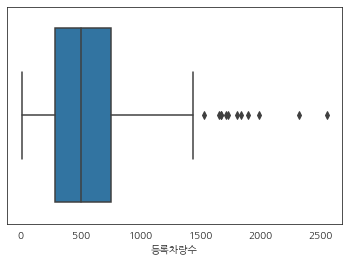

In [896]:
### outlier 제거
sns.boxplot(df_agg['등록차량수'])

In [897]:
outlier_index = df_agg[df_agg['등록차량수']>1500].index
print(outlier_index)
df_agg.drop(outlier_index,inplace=True)
train_ids = df_agg[~df_agg.등록차량수.isna()].index

Index(['C1244', 'C1013', 'C2620', 'C1743', 'C1350', 'C1129', 'C1933', 'C2612',
       'C1363', 'C1802', 'C1939', 'C2086'],
      dtype='object', name='단지코드')


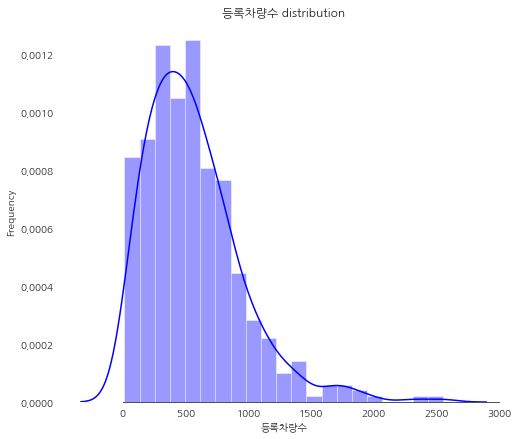

In [898]:
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train_agg[target_feature], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel=target_feature)
ax.set(title=f"{target_feature} distribution")
sns.despine(trim=True, left=True)
plt.show()

### 오른쪽에 꼬리가 있다

In [899]:
# log(1+x) transform
train_agg[target_feature]= np.sqrt(train_agg[target_feature])


 mu = 22.36 and sigma = 8.01



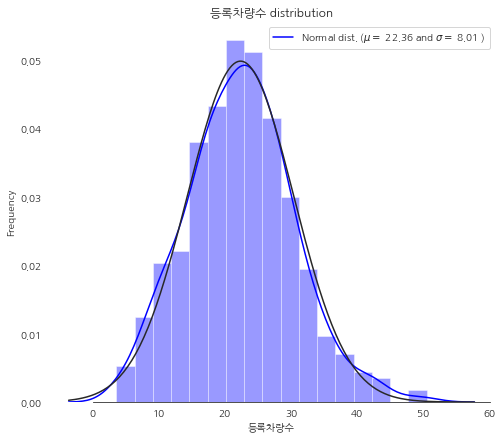

In [900]:
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train_agg[target_feature] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_agg[target_feature])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel= target_feature)
ax.set(title=f"{target_feature} distribution")
sns.despine(trim=True, left=True)

plt.show()

### 적용반영
df_agg[target_feature]= np.sqrt(df_agg[target_feature])

# variable skewness 평가

In [901]:
#numeric_features 재계산
numeric_features = df_agg.select_dtypes(exclude="object").columns.drop(['등록차량수']).tolist()

In [902]:
# Find skewed numerical features
skew_features = df_agg[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 56 numerical features with Skew > 0.5 :


지역_세종특별자치시         13.416613
공공임대(50년)_count     9.975497
L_count             9.713115
K_count             9.647493
지역_서울특별시            9.408031
K_existence         8.685706
E_count             7.677873
L_existence         7.205453
J_count             6.834563
공공임대(10년)_count     6.539548
dtype: float64

In [903]:
# Normalize skewed features
for i in skew_index:
    df_agg[i] = boxcox1p(df_agg[i], boxcox_normmax(df_agg[i] + 1))

### Create Some more interesting features

In [904]:
portion_columns = ['20.0_portion','30.0_portion', '40.0_portion', '50.0_portion', '60.0_portion']
for column in portion_columns:
    df_agg[column+'*총세대수'] = df_agg[column]*df_agg['총세대수']

### log transformation

In [905]:
df_agg.columns

Index(['총세대수', '공가수', '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수', '상가_existence',
       '공공임대(10년)_existence', '공공임대(50년)_existence', '국민임대_existence',
       '영구임대_existence', '임대상가_existence', '행복주택_existence', 'A_existence',
       'C_existence', 'D_existence', 'E_existence', 'H_existence',
       'I_existence', 'J_existence', 'K_existence', 'L_existence', '상가_count',
       '공공임대(10년)_count', '공공임대(50년)_count', '국민임대_count', '영구임대_count',
       '임대상가_count', '행복주택_count', 'A_count', 'C_count', 'D_count', 'E_count',
       'H_count', 'I_count', 'J_count', 'K_count', 'L_count', '20.0_portion',
       '30.0_portion', '40.0_portion', '50.0_portion', '60.0_portion',
       '전용면적*전용면적별 세대수', '전용면적*전용면적별 세대수/총 세대수', '호수/총대수', 'men_women_sum',
       '지역_강원도', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시', '지역_대구광역시',
       '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시', '지역_울산광역시', '지역_전라남도',
       '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도', '20.0_portion*총세대수',
       '30.0_portion*총

In [906]:
###log_transformation
log_columns = ['단지내주차면수', '전용면적*전용면적별 세대수','총세대수','전용면적*전용면적별 세대수/총 세대수', '공가수','20.0_portion*총세대수', '30.0_portion*총세대수', '40.0_portion*총세대수',
       '50.0_portion*총세대수', '60.0_portion*총세대수']

In [907]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res


df_agg = logs(df_agg, log_columns)

###squares_transformation

In [908]:
squared_columns=['men_women_sum','호수/총대수', '상가_count',
       '공공임대(10년)_count', '공공임대(50년)_count', '국민임대_count', '영구임대_count',
       '임대상가_count', '행복주택_count', 'A_count', 'C_count', 'D_count', 'E_count',
       'H_count', 'I_count', 'J_count', 'K_count', 'L_count' ]

In [909]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

df_agg = squares(df_agg, squared_columns)

### 전처리 확인 끝

In [910]:
#X,y, X_test
X=df_agg.loc[train_ids].drop(target_col, axis=1)
y=df_agg.loc[train_ids,target_col]
X_test= df_agg.loc[test_ids].drop(target_col,axis=1)

# ##cross_val_test
catb = CatBoostRegressor(
    #cat_features=cat_features,
    loss_function='MAE',
    iterations=1000,
    learning_rate=0.05,
    verbose=1000
)
kfold = KFold(10,shuffle=True, random_state=217)
val_score = cross_val_score(catb, X, y, cv=kfold, scoring='neg_mean_absolute_error',verbose=1000)
print("---cross val score---")
print(np.mean(val_score))


In [911]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [912]:
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=10,
                       learning_rate=0.05, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)
# lightgbm = LGBMRegressor(objective='regression', 
#                        verbose=-1,
#                        random_state=42)
#Catboost Regressor
catb = CatBoostRegressor(
    #cat_features=cat_features,
    loss_function='MAE',
    iterations=1000,
    learning_rate=0.05,
    verbose=1000
)
# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# xgboost = XGBRegressor(colsample_bytree=0.7,
#                        objective='reg:linear',
#                        nthread=-1,
#                        random_state=42)


# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))



# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  
# gbr = GradientBoostingRegressor(
#                                 random_state=42)  


# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)
# rf = RandomForestRegressor(
#                           oob_score=True,
#                           random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, ridge, gbr, rf, catb),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [913]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] baggi

In [914]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[17:30:21] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:30] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:40] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:49] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:30:59] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:08] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:18] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is no

In [915]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 151.4926 (25.6831)


In [916]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 155.0569 (28.8992)


In [917]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 165.9055 (25.3210)


In [918]:
score = cv_rmse(catb)
print("catb: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['catb'] = (score.mean(), score.std())

0:	learn: 246.5173962	total: 1.07ms	remaining: 1.07s
999:	learn: 14.3613368	total: 2.41s	remaining: 0us
0:	learn: 251.0442454	total: 3.32ms	remaining: 3.31s
999:	learn: 13.8303673	total: 2.3s	remaining: 0us
0:	learn: 242.9964372	total: 2.51ms	remaining: 2.51s
999:	learn: 15.1597368	total: 2.44s	remaining: 0us
0:	learn: 240.6837421	total: 982us	remaining: 982ms
999:	learn: 12.7023488	total: 2.48s	remaining: 0us
0:	learn: 247.4428951	total: 2.43ms	remaining: 2.43s
999:	learn: 14.9958100	total: 2.38s	remaining: 0us
0:	learn: 250.0443978	total: 2.22ms	remaining: 2.21s
999:	learn: 14.2179889	total: 2.4s	remaining: 0us
0:	learn: 250.2536874	total: 2.25ms	remaining: 2.24s
999:	learn: 13.9944159	total: 2.38s	remaining: 0us
0:	learn: 245.4778677	total: 2.24ms	remaining: 2.24s
999:	learn: 14.5346841	total: 2.38s	remaining: 0us
0:	learn: 243.3685781	total: 2.33ms	remaining: 2.33s
999:	learn: 14.3722008	total: 2.39s	remaining: 0us
0:	learn: 245.8561464	total: 2.05ms	remaining: 2.05s
999:	learn: 13

### fit the models

In [919]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), y)

stack_gen
[17:35:39] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:44] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:50] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:55] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:00] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [920]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

lightgbm


In [921]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

xgboost
[17:38:10] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


In [922]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

Ridge


In [923]:
print('RandomForest')
rf_model_full_data = rf.fit(X, y)

RandomForest


In [924]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

GradientBoosting


In [925]:
print('Catboost')
catboost_model_full_data = catb.fit(X, y)

Catboost
0:	learn: 245.5657884	total: 2.01ms	remaining: 2.01s
999:	learn: 16.4558293	total: 2.49s	remaining: 0us


In [926]:
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X))[:,0] + \
            (0.1 * catboost_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.1 * rf_model_full_data.predict(X)) + \
            (0.4 * stack_gen_model.predict(np.array(X))))

In [927]:
# Get final precitions from the blended model
blended_score = rmsle(y, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
59.89688920293201


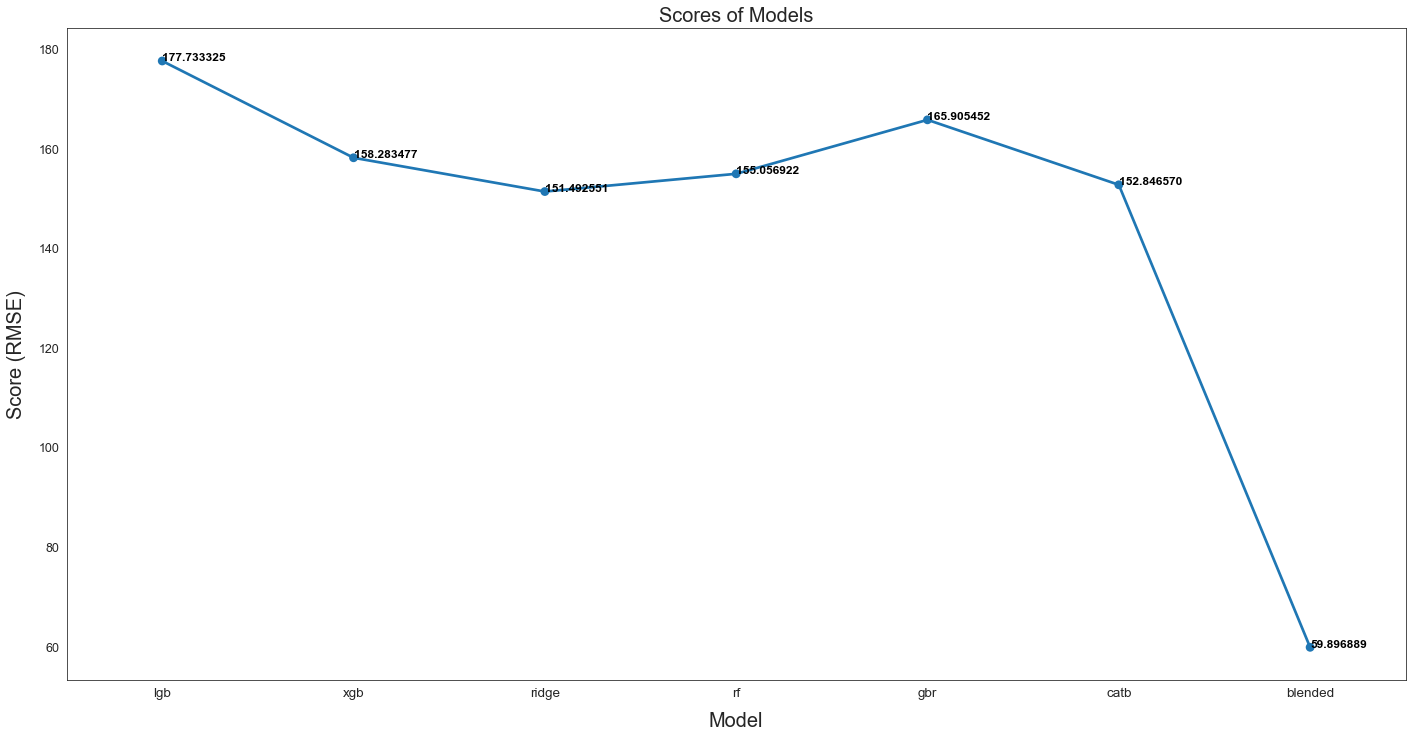

In [928]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [929]:
sample_submission['num'] =  blended_predictions(X_test)

In [930]:
np.mean(sample_submission['num'])

524.8606389170001

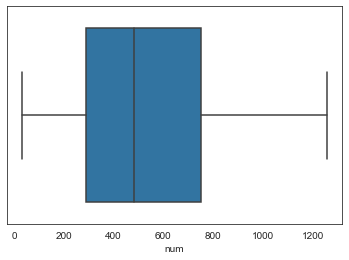

In [931]:
sns.boxplot(sample_submission['num'])

In [932]:
sample_submission.to_csv("submission_regression1.csv", index=False)

# Fix outleir predictions
q2 = sample_submission['num'].quantile(0.99)
sample_submission['num'] = sample_submission['num'].apply(lambda x: x if x > q1 else x*0.7)
sample_submission.to_csv("submission_regression2.csv", index=False)

scale = np.mean( np.expm1(y)) / np.mean(sample_submission['num'])

sample_submission['num']*=1.001619

sample_submission.to_csv("submission_regression3.csv", index=False)